# Bayesian modeling of StarCraft II ladder performance

I've been in a bit of a pickle recently. I really need to figure out Bayesian inference as practice for my masters' thesis. I've been wondering, *what kind of cool project - hopefully with my own data - could I make?*, I thought as I fired up StarCraft II in the evening, as I usually do to unwind nowadays. *What kind of fun use of [PyMC3, the neat Python library for probabilistic programming](https://docs.pymc.io/), could I showcase?*, I wondered as I watched my ladder ratings fall from the distraction. *What kind of useful knowledge could I try to acquire using it?*, I thought, watching my game performance fluctuate over the course of months.

And then it hit me.

<!-- TEASER_END -->

In this post, I'm going to use PyMC3 to analyse my 2019 StarCraft II ladder games. In particular, I'm going to look at the relation between MMR - MatchMaking Rating, a metric of ladder performance  - mine and that of my enemies - and what it can tell us about my win chances.

## A few facts about StarCraft

* SC2 is a fast-paced real-time action/strategy game played competitively all over the world;
* Each game of SC2 lasts about 10-30 minutes;
* There are three *races* in SC2, which means factions, each with a completely different playstyle and toolset; I play Protoss (the advanced space aliens) and the other two ~~suck~~ are Terran (scrappy future humans) and Zerg (hivemind insectoid aliens).
    * There is no tribal animosity between players of the races in the community whatsoever.
* Each 1v1 game pits two randomly selected players of similar MMR. Better players have higher MMR, and it's used to find **worthy** (adequate) **opponents** for you. A Protoss player has three different possible matchups - Protoss vs Protoss (PvP), PvT and PvZ.

## A few facts about Bayesian inference

* it's an alternate, computationally intensive approach to statistics (of which you probably know frequentist statistics)
* it's a really neat tool to formulate complex models of processes occuring between entities
* it can let you infer knowledge about quantities not directly included in your data at all (so-called "latent" quantities)
* it can combine data with your initial assumptions ("priors") or initial beliefs about quantities in your system
    * this means you need to explicitly state what you believe about the data first
* it returns probability distributions for your parameters, rather than simple point estimates like means or variances
    * this makes handling asymmetric uncertainties and error bars much easier
* it's a great framework for learning new knowledge from data, as I'll try to show

In this post, we're going to use my own dataset of ladder replays. The motivation is this: there are days when I play terribly and there are days when I play my heart out. It does, however, feel like my performance fluctuates a lot. I thought I could use Bayesian modelling to learn something about these fluctuations.

I was going to have an example of pulling this data using [ZephyrBlu's replay parser library](https://github.com/ZephyrBlu/zephyrus-sc2-parser/) and an unreleased custom wrapper I have for that. However, since I'm getting a ton of warnings that would distract from the main ideas, in the name of simplicity I'll just post the parsed version on GitHub. I'll come back to parsing those once I finish that library of mine.

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/StanczakDominik/stanczakdominik.github.io/src/files/replays.csv", index_col=0)
df['time_played_at'] = pd.to_datetime(df.time_played_at)
df

,time_played_at,win,race,enemy_race,mmr,mmr_diff,enemy_nickame
0,2020-05-27 10:32:29+00:00,True,Protoss,Terran,4004,-169,giletjaune
1,2020-06-09 17:11:15+00:00,False,Protoss,Zerg,4186,39,djakette
2,2020-02-02 17:27:27+00:00,True,Protoss,Terran,3971,58,Syocto
3,2019-12-20 18:53:00+00:00,True,Zerg,Terran,2984,-106,Jason
4,2019-12-09 20:36:21+00:00,True,Protoss,Zerg,4015,-9,&lt;OGCOСK&gt;<sp/>ShushYo
...,...,...,...,...,...,...,...
432,2019-11-04 20:53:20+00:00,False,Protoss,Terran,3800,-83,&lt;MiClan&gt;<sp/>MiSHANYA
433,2020-05-04 12:43:06+00:00,True,Protoss,Terran,3926,95,StaMinA
434,2020-02-02 17:15:06+00:00,False,Protoss,Zerg,4012,-80,&lt;0mg&gt;<sp/>Sroljo
435,2020-04-19 11:48:32+00:00,True,Protoss,Zerg,0,0,shadowofmich


# MMR vs Elo

We're going to need to figure out a way to connect MMR to winning probabilities. Each game won awards a certain amount of MMR which depends on the difference between the two players' pre-match MMR. If you win against a player you weren't expected to beat, the system awards you more MMR - and the other player loses the exact large amount.

Interestingly, according to some wonderful sleuthing by [u/MisterL2 on r/starcraft](https://www.reddit.com/r/starcraft/comments/6dn6jf/does_anybody_have_more_detailed_stats_on_mmr/di3yg0x/), MMR is basically the classic [chess Elo rating](https://en.wikipedia.org/wiki/Elo_rating_system), except for a simple scaling - 100 Elo is basically 220 MMR. With the Elo estimated win percentage formula depending on the difference in Elo ($\Delta_{Elo}$) as

$$ P(\text{win}) = \left(1 + 10^{-\Delta_{Elo}/400}\right)^{-1} $$

We can adjust to MMR as

$$ P(\text{win}) = \left(1 + 10^{-\Delta_{MMR}/880}\right)^{-1} $$

As a quick check, let's compare with the [sample data provided](https://imgur.com/a/Suj8E):

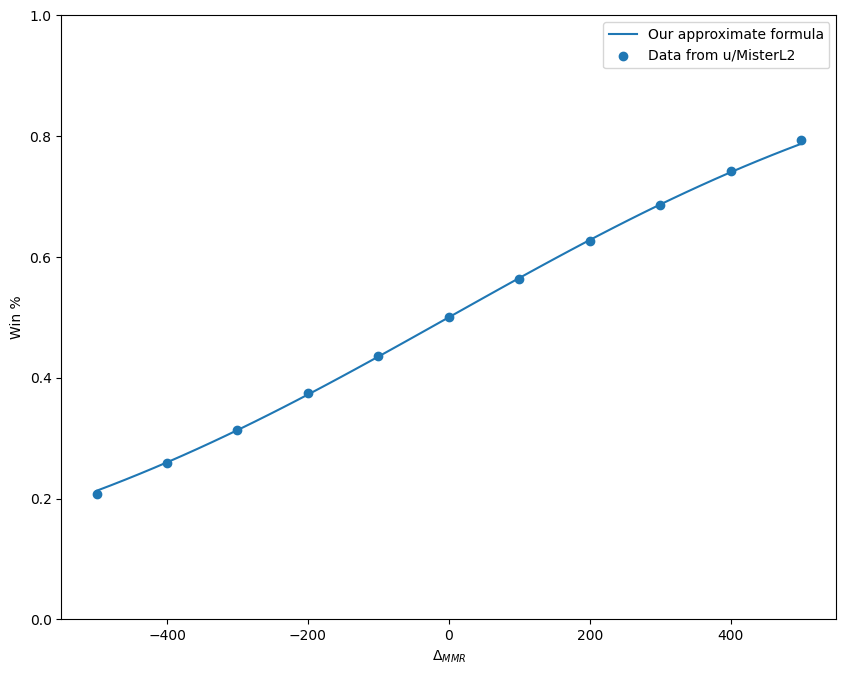

In [2]:
def MMR_winrate(diff):
    return 1 / (1 + 10**(-diff/880))

diffs = np.arange(0, 600, 100)
diffs = np.concatenate([-diffs[:0:-1], diffs])
winrates = np.array([0.5, 0.564, 0.626, 0.686, 0.742, 0.793])
winrates = np.concatenate([1-winrates[:0:-1], winrates])
plt.scatter(diffs, winrates, label = "Data from u/MisterL2")
diffs_plot = np.linspace(diffs.min(), diffs.max())
approx = MMR_winrate(diffs_plot)
plt.plot(diffs_plot, approx, label = "Our approximate formula")
plt.legend()
plt.setp(plt.gca(), xlabel=r"$\Delta_{MMR}$", ylabel = "Win %", ylim=(0,1));

Splendid. 

# Digging into the data

We'll need the MMR differences, and we'll use those to calculate the expected winrates:

In [3]:
df = df.sort_values('time_played_at')
df['enemy_mmr'] = df['mmr'] - df['mmr_diff']
df['expected_winrate'] = MMR_winrate(df.mmr_diff)
df

,time_played_at,win,race,enemy_race,mmr,mmr_diff,enemy_nickame,enemy_mmr,expected_winrate
155,2019-09-11 15:22:43+00:00,True,Protoss,Terran,-36400,-39206,winstrol,2806,2.803672e-45
396,2019-09-11 15:35:39+00:00,True,Zerg,Zerg,-36400,-38905,OtecAnisim,2505,6.162724e-45
321,2019-09-12 10:42:41+00:00,True,Protoss,Terran,-36400,-38579,ujptm,2179,1.446196e-44
373,2019-09-12 10:53:37+00:00,True,Protoss,Terran,-36400,-38935,&lt;klko&gt;<sp/>marauder,2535,5.697467e-45
408,2019-09-12 16:28:28+00:00,True,Protoss,Terran,-36400,-39229,Toidak,2829,2.639921e-45
...,...,...,...,...,...,...,...,...,...
145,2020-06-04 19:18:46+00:00,True,Protoss,Zerg,4181,-189,&lt;AiRǂ&gt;<sp/>SuperNova,4370,3.788264e-01
255,2020-06-09 16:57:17+00:00,True,Protoss,Protoss,0,0,A.I. 1 (Elite),0,5.000000e-01
79,2020-06-09 17:03:47+00:00,False,Protoss,Protoss,4208,14,Ziiim,4194,5.091570e-01
1,2020-06-09 17:11:15+00:00,False,Protoss,Zerg,4186,39,djakette,4147,5.254895e-01


In [4]:
import altair

altair.Chart(df).mark_circle().encode(
    altair.X('time_played_at'),
    altair.Y('mmr',
             scale=altair.Scale(zero=False)),
    color='enemy_race',
).interactive()

alt.Chart(...)

There are a couple of clear outliers:

* there are some games at a MMR of -36400; I may be bad at StarCraft, but not that bad. I'm not willing to trust our replay parser about them, so I'll just throw these out.
* the games at a MMR of 0 are mostly custom or vs AI games. Those are recorded in replays as well. We'll dump them too.
* there are few games where I offraced as Zerg, and the game tracks a separate MMR for each race you play as. We'll skip those as well and look only at the Protoss perspective. This

In [5]:
data = df[(df.mmr > 0) & (df.enemy_mmr > 0) & (df.race == "Protoss")]
data

,time_played_at,win,race,enemy_race,mmr,mmr_diff,enemy_nickame,enemy_mmr,expected_winrate
428,2019-10-06 12:23:56+00:00,True,Protoss,Protoss,3751,25,MJM,3726,0.516348
8,2019-10-06 12:36:36+00:00,True,Protoss,Protoss,3826,78,vasea,3748,0.550847
322,2019-10-08 19:33:28+00:00,False,Protoss,Protoss,3893,-53,Wavelength,3946,0.465386
54,2019-10-10 07:41:27+00:00,False,Protoss,Zerg,3828,26,PereiRa,3802,0.517001
343,2019-10-10 07:55:19+00:00,True,Protoss,Zerg,3760,-56,&lt;PROOO&gt;<sp/>Jesperpro,3816,0.463433
...,...,...,...,...,...,...,...,...,...
285,2020-06-04 19:03:54+00:00,False,Protoss,Terran,4203,21,JOOPSTAR,4182,0.513734
145,2020-06-04 19:18:46+00:00,True,Protoss,Zerg,4181,-189,&lt;AiRǂ&gt;<sp/>SuperNova,4370,0.378826
79,2020-06-09 17:03:47+00:00,False,Protoss,Protoss,4208,14,Ziiim,4194,0.509157
1,2020-06-09 17:11:15+00:00,False,Protoss,Zerg,4186,39,djakette,4147,0.525489


In [6]:
altair.Chart(data).mark_circle().encode(
    altair.X('time_played_at'),
    altair.Y('mmr',
             scale=altair.Scale(zero=False)),
    color='enemy_race',
).interactive()

alt.Chart(...)

I'd say it's a steady climb upwards, but sometimes it feels nothing like that.

I'm also going to limit my current analysis to 2019 replays (I did have more before October, but I think I lost them somewhere):

In [7]:
data2019 = data[(data['time_played_at'] > '2019-01-01') & (data['time_played_at'] < '2020-01-01')]
data2019

,time_played_at,win,race,enemy_race,mmr,mmr_diff,enemy_nickame,enemy_mmr,expected_winrate
428,2019-10-06 12:23:56+00:00,True,Protoss,Protoss,3751,25,MJM,3726,0.516348
8,2019-10-06 12:36:36+00:00,True,Protoss,Protoss,3826,78,vasea,3748,0.550847
322,2019-10-08 19:33:28+00:00,False,Protoss,Protoss,3893,-53,Wavelength,3946,0.465386
54,2019-10-10 07:41:27+00:00,False,Protoss,Zerg,3828,26,PereiRa,3802,0.517001
343,2019-10-10 07:55:19+00:00,True,Protoss,Zerg,3760,-56,&lt;PROOO&gt;<sp/>Jesperpro,3816,0.463433
...,...,...,...,...,...,...,...,...,...
388,2019-12-27 20:24:27+00:00,False,Protoss,Zerg,3933,-100,HiveMind,4033,0.434956
25,2019-12-27 20:40:39+00:00,True,Protoss,Zerg,3914,0,Racin,3914,0.500000
205,2019-12-27 21:24:06+00:00,True,Protoss,Terran,3936,-41,&lt;DemuCl&gt;<sp/>Jazzz,3977,0.473206
59,2019-12-28 20:58:25+00:00,True,Protoss,Terran,3959,22,rOoSter,3937,0.514387


In [8]:
altair.Chart(data2019).mark_circle().encode(
    altair.X('time_played_at'),
    altair.Y('mmr',
             scale=altair.Scale(zero=False)),
    color='enemy_race',
).interactive()

alt.Chart(...)

We can now take a look at whether our `expected_winrate` metric makes sense:

In [9]:
altair.Chart(data2019).mark_circle().encode(
    x=altair.X('enemy_mmr', scale=altair.Scale(zero=False)),
    y=altair.Y('expected_winrate'),
    color='win',
).interactive()

alt.Chart(...)

Seems like it! The higher up in enemies we go, the less the chances of winning become.

## Digression - race separated data

[Altair](https://altair-viz.github.io/) makes it very easy to look at data from each of the matchups in the dataset:

In [10]:
altair.Chart(data2019).mark_circle().encode(
    x=altair.X('enemy_mmr', scale=altair.Scale(zero=False)),
    y=altair.Y('expected_winrate'),
    color='win',
    facet='enemy_race',
).interactive()

alt.Chart(...)

There are a few things we can already say from this:

* Enemy Protosses at 4k MMR were already a large challenge, as I won no games whatsoever against those. This is, in fact, what inspired me to write this post!
* PvT was my best matchup - there are the most wins there.
* PvZ games were mostly even, though there are a good amount of lost games that I should probably have won! This seems to point to MMR not being enough to estimate my winrate properly - for example, strategical variation in Zerg play. I'm still sort of confused on what to do with a very defensive, lategame-oriented Zerg player.

Let's see if our estimates were right: 

In [11]:
data2019.groupby('enemy_race').win.mean()

enemy_race
Protoss    0.309524
Terran     0.729167
Zerg       0.519231
Name: win, dtype: float64

Ouch. That PvP still hurts. Well, enough sulking! We'll get back to this point later - promise - but for nowo, let's get right to

# The Bayesian model

The idea is going to be simple. I'm going to assume that:

1. my true MMR is some random number about 4k, oscillating at most 300 up and down from that number: $\mu \sim \text{Normal}(4000, 300)$.
2. in each game, my effective MMR is a random normal variable $\text{MMR}^n \sim \text{Normal}(\mu, \sigma)$ (where by the superscript I denote the fact that we're sampling n of these, one per game) that includes a ton of effects, some of which can be:
    1. the size of my breakfast of that day
    2. time of day
    3. enemy race
    4. whether I'd exercised before (I should really start tracking that, come to think of it...)
    5. the map the game is played on
3. I have no idea how much my effective per-game MMR varies, so I'm just going to say the variance of MMR is going to be some positive number, and I'll assume a half-normal distribution with a scale of 100: $\sigma \sim \text{HalfNormal}(100)$. Let's take a look at that distribution:

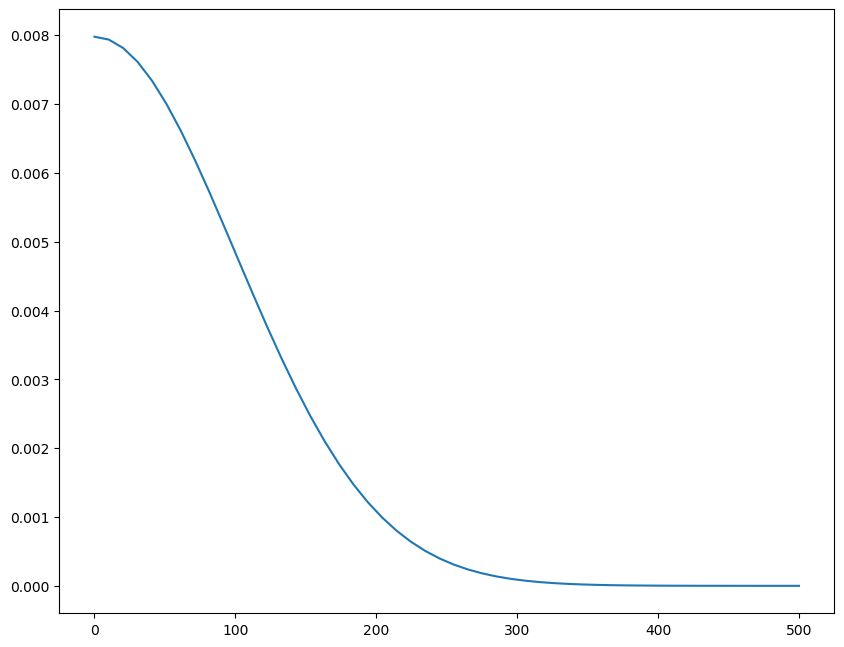

In [12]:
from scipy.stats import halfnorm
x = np.linspace(0, 500)
PDF = halfnorm(scale=100).pdf(x)
plt.plot(x, PDF);

which is another way of saying "some positive number, small-ish, probably not larger than 200".

Okay, but that's the MMR. We need some way of connecting that to our won and lost games! Luckily, we have the `MMR_winrate` formula: we know that the ladder system essentially models
each game as a biased coin *(Pro)* toss (that joke is much funnier when you're the Protoss on the ladder), with the bias being equal to the estimated winrate. The probability of a coin toss giving heads is usually modelled with the Bernoulli distribution.

Let's now go ahead and use PyMC3 to encode that into a Bayesian model:

In [13]:
import pymc3 as pm
import arviz as az

with pm.Model() as bernoulli_model:
    mmr_μ = pm.Normal('μ', 4000, 300)
    mmr_σ = pm.HalfNormal('σ', 100)
    mmr = pm.Normal('MMR', mmr_μ, mmr_σ, shape=data2019.enemy_mmr.size)

Note the `shape` part - we sample one effective MMR for each game in the dataset. Now, we deal with calculating the expected winrates for our games:

In [14]:
with bernoulli_model:
    diffs = pm.Deterministic('MMR_diff', mmr - data2019.enemy_mmr)
    p = pm.Deterministic('winrate', MMR_winrate(diffs))

`Deterministic` variables are stuff that depends in a predictable way on your random variables, once you know their values. We could skip that, but I label them as `Deterministic` to easily track them later.

We can now add the actual data using the `observed` keyword:

In [15]:
with bernoulli_model:
    wl = pm.Bernoulli('win', p=p, observed=data2019.win)

And now we press the magic inference `pymc3.sample` button! I'll go into details on it another time (when I understand it better myself!). In a nutshell, though, `sample` is going to launch a few "random walks" (Hamiltonian simulations of particle motion, technically! Those are the details I wasn't going to explore today...) in parameter space. Ideally, these can explore a good amount of parameter value sets and find ones that fit the data well.

I'll also wrap it in the neat `arviz` Bayesian visualization library.

If you're running this live, this is a good time to put the kettle on:

In [16]:
with bernoulli_model:
    bern_data = az.from_pymc3(trace=pm.sample(2000, tune=2000, chains=4))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [MMR, σ, μ]
Sampling 4 chains, 1,297 divergences: 100%|██████████| 16000/16000 [00:44<00:00, 360.37draws/s]
There were 927 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23962550742848526, but should be close to 0.8. Try to increase the number of tuning steps.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
There were 249 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6604859684507034, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated nu

Aaaaand everything crashed. We can take a look at these results, but they won't be pretty:

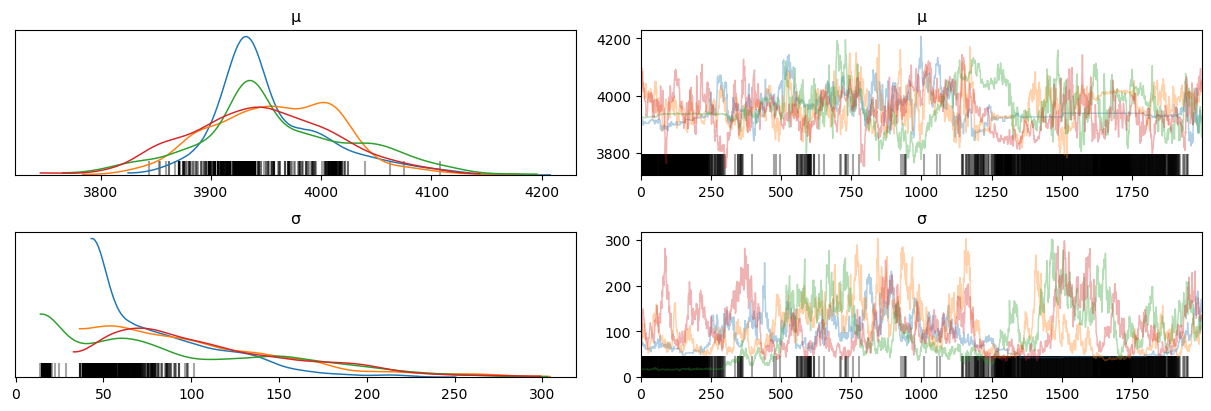

In [17]:
var_names = ['μ', 'σ']
az.plot_trace(bern_data, var_names=var_names);

Each colored line represents each of the trajectories, with histograms of their values on the left, and actual (pseudo)time trajectories during the sampling on the right. As we can see, the chains don't exactly agree with each other. Divergences (vertical lines at the bottom... yeah) mean that our random walkers, or probability space particles, flew off to infinity, forgetting all about energy conservation and that kind of jazz. A model with divergences is... basically, bad. They didn't manage to sample parameters well, getting stuck in multiple regions of parameter space, with slow variations and definitely not independent steps. This completely messes up the histograms. If the chains disagree as badly as they do here, well, that's not a model to be trusted.

We can also look at where in particular in parameter space the model started having trouble:

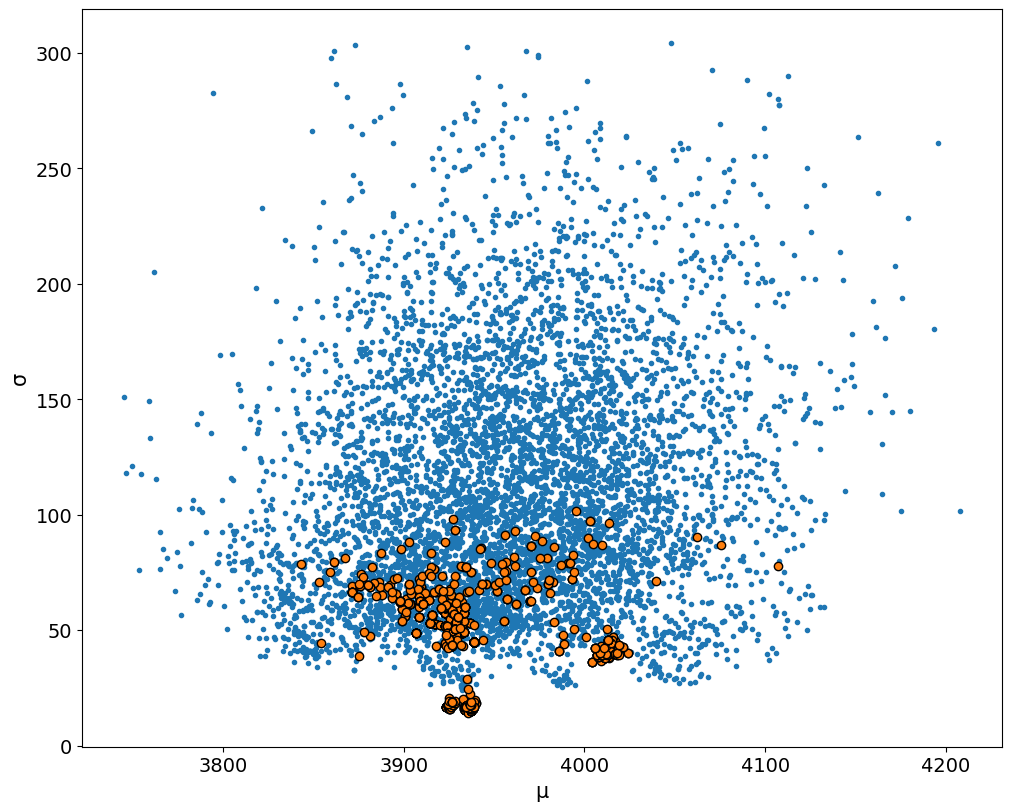

In [18]:
az.plot_pair(bern_data, var_names=var_names, divergences=True);

Well, there's clearly some issues at the bottom, at low values of $\sigma$. It is, however, kind of unhelpful.

I don't quite understand the next part myself just yet, but as I (probably not particularly well) think of it: what people usually do in this case is decouple sampling the **amplitude** or **variance** $\sigma$ of our estimated MMR from sampling the **direction** and **value** of each particular iteration, and from the mean itself. We treat the mean as we did before:

$$\mu \sim \text{Normal}(4000, 300)$$

We'll also take the variance as usual:

$$\sigma \sim \text{HalfNormal}(100)$$

What we'll also do, however, is grab a set of normal variables:

$$\sigma_\text{norm}^n \sim \text{Normal}(0, 1)$$

And we'll calculate the effective MMR per game as:

$$\text{MMR}^n = \mu + \sigma * \sigma_\text{norm}^n$$

This is called a noncentered formulation, and is a big deal apparently. If I'm correct, it makes exploring variations in the amplitude easier when the possibly small variations from the separate normal helper random variables are disconnected from it, and from the mean. More about this as I know more about this.

Without further ado, the corrected model:

In [19]:
with pm.Model() as bernoulli_model_noncentered:
    mmr_μ = pm.Normal('μ', 4000, 300)
    mmr_σ = pm.HalfNormal('σ', 100)
    mmr_σ_norm = pm.Normal('σ_norm', 0, 1, shape=data2019.enemy_mmr.size)
    
    mmr = pm.Deterministic('MMR', mmr_μ + mmr_σ * mmr_σ_norm)
    diffs = pm.Deterministic('MMR_diff', mmr - data2019.enemy_mmr)
    p = pm.Deterministic('winrate', MMR_winrate(diffs))
    
    wl = pm.Bernoulli('win', p=p, observed=data2019.win)
    
    trace = pm.sample(2000, tune=2000, chains=4)
    bern_noncentered_data = az.from_pymc3(
        trace=trace,
        prior=pm.sample_prior_predictive(),
        posterior_predictive=pm.sample_posterior_predictive(trace),
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ_norm, σ, μ]
100%|██████████| 8000/8000 [00:06<00:00, 1187.82it/s]


That seems to have worked nicely!

In [20]:
var_names = ['μ', 'σ']
az.summary(bern_noncentered_data, var_names=var_names) 

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,3972.677,65.433,3849.004,4094.180,0.550,0.389,14148.0,14148.0,14160.0,5935.0,1.0
σ,80.602,60.331,0.018,188.067,0.787,0.592,5879.0,5193.0,5308.0,4121.0,1.0


So my true MMR in 2019 was somewhere around 3973, with a standard deviation of ~65. A more Bayesian approach is saying that we can say with 97% (I'm not completely sure it's not 94%, because of symmetry...) certainty that the true MMR is between 3850 and 4094. That's the Highest Posterior Density - hpd - metric.

Note how this standard deviation is an okay metric for the non-gaussian $\mu$, but completely fails to make any sense for $\sigma$, where I'm just going to say I'm 97% sure it's not larger than 188, with a mean of 81.

Also note that HPD means what it means - we're 97% (or 94%, because I'm not sure about that detail!) sure that the variable is in these bounds, according to this model. The comparable metric in frequentist statistics - the $\chi^2$ test - says... something that nobody really understands. I can find the papers on that for you if you'd like, but basically... people think it says what HPD says, and it doesn't, really.

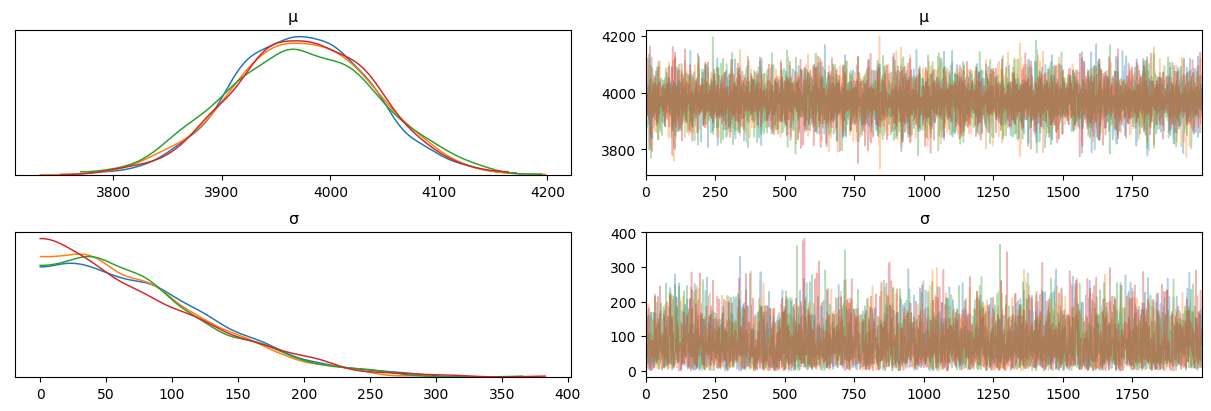

In [21]:
az.plot_trace(bern_noncentered_data, var_names=var_names);

The chains mostly agree on the values!

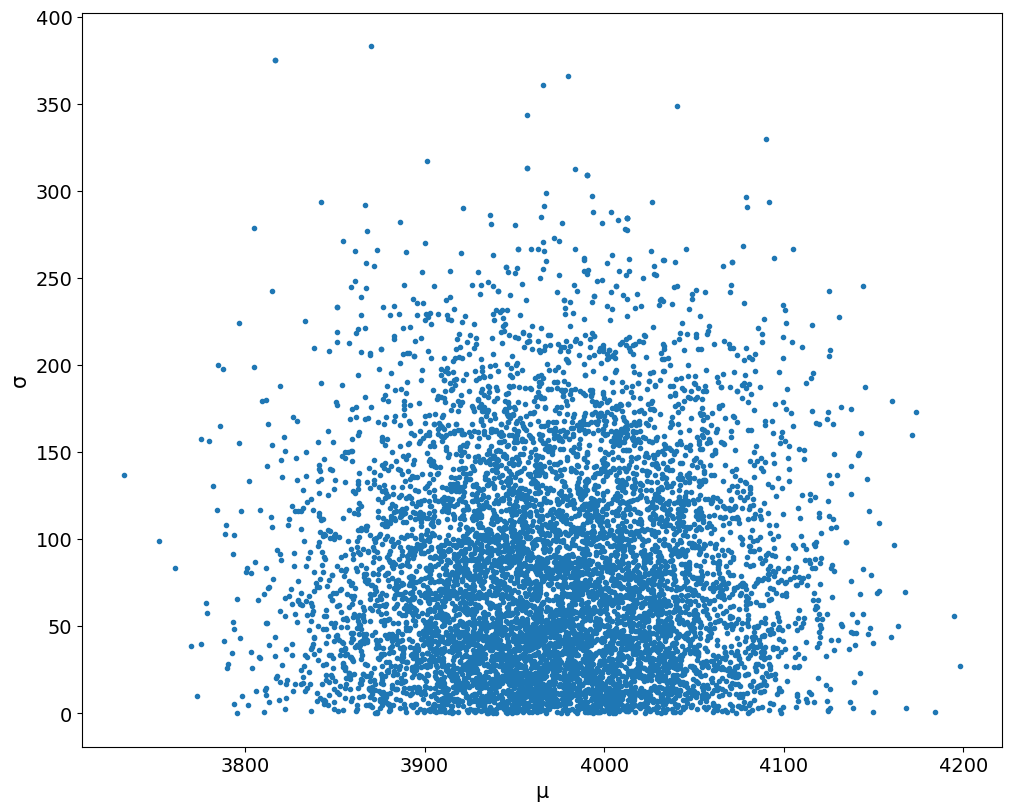

In [23]:
az.plot_pair(bern_noncentered_data, var_names=var_names, divergences=True);

We can also compare the prior (our assumptions) and the posterior (the results of our model):

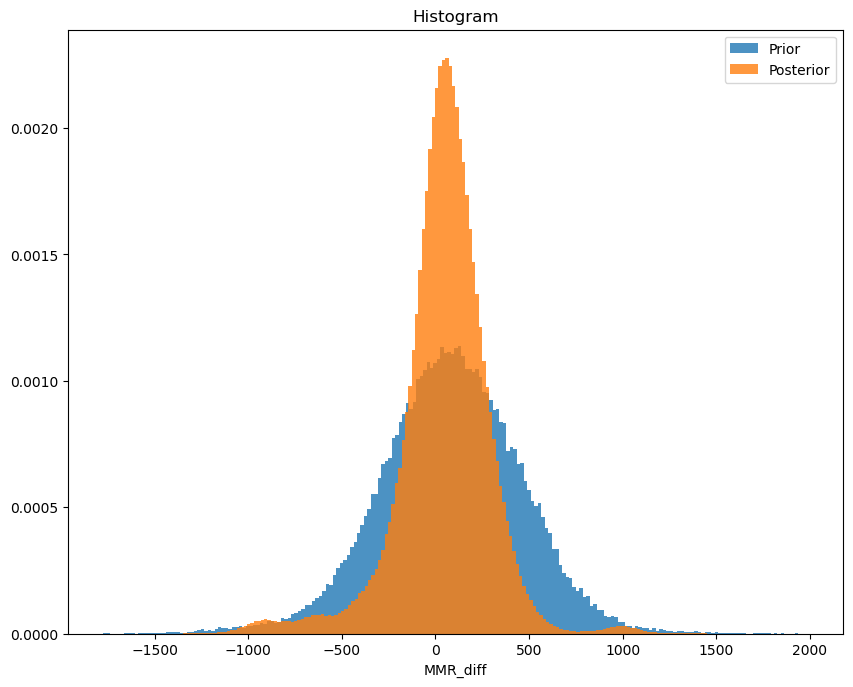

In [24]:
fig, ax = plt.subplots()
bern_noncentered_data.prior.MMR_diff.plot.hist(bins=200, ax=ax, density=True, alpha=0.8, label="Prior");
bern_noncentered_data.posterior.MMR_diff.plot.hist(bins=200, ax=ax, density=True, alpha=0.8, label="Posterior");
ax.legend();

For the MMR difference, the distribution got peaked: which makes sense! The game doesn't usually find me opponents 500 MMR away from mine!

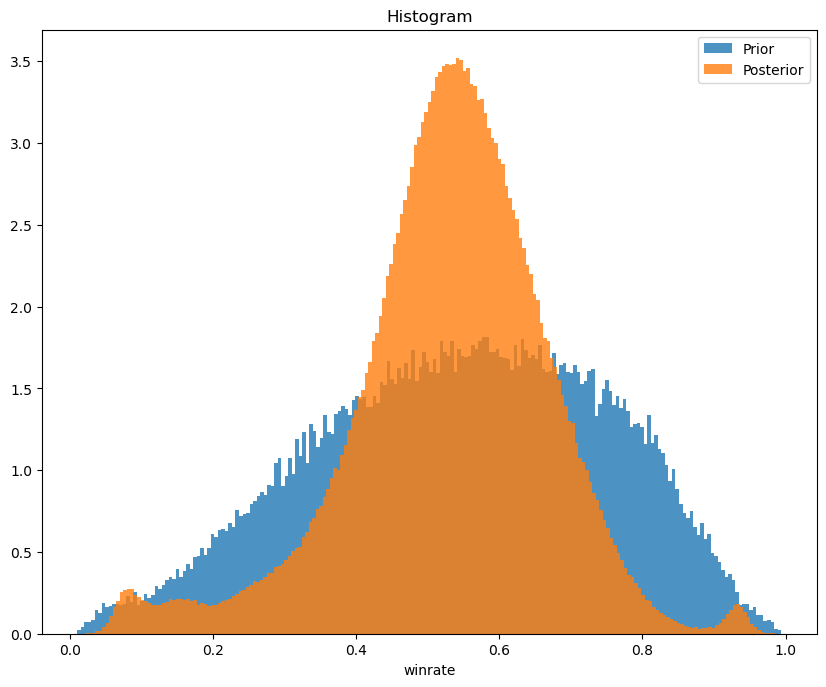

In [25]:
fig, ax = plt.subplots()
bern_noncentered_data.prior.winrate.plot.hist(bins=200, ax=ax, density=True, alpha=0.8, label="Prior");
bern_noncentered_data.posterior.winrate.plot.hist(bins=200, ax=ax, density=True, alpha=0.8, label="Posterior");
ax.legend();

The winrate got closer in mean to 50%, which is what the system tries to optimize for. Reasonable! Note that the prior seems to not have been all that good - it predicted a winrate of more than 50%! Could have been better, but it seems to have handled the adjustment nicely.

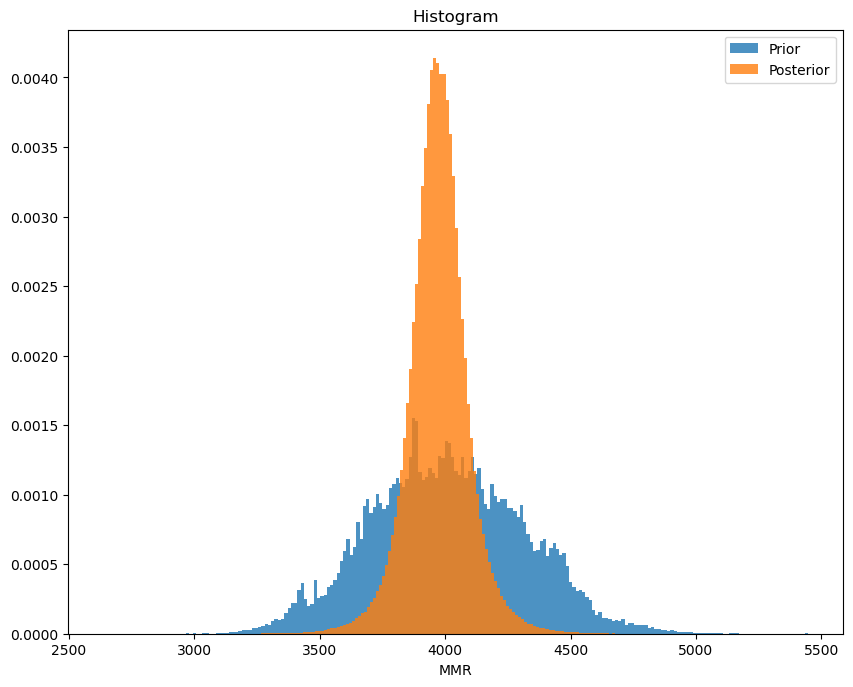

In [26]:
fig, ax = plt.subplots()
bern_noncentered_data.prior.MMR.plot.hist(bins=200, ax=ax, density=True, alpha=0.8, label="Prior");
bern_noncentered_data.posterior.MMR.plot.hist(bins=200, ax=ax, density=True, alpha=0.8, label="Posterior");
ax.legend();

And it definitely got more confident about my MMR being just below 4k!

# Where to from here?

This was just the basic overview, and honestly - the same analysis could probably have been handled using frequentist methods. We had a good number of data points. Call `.mean()`, call `.std()`, call it a day, right?

**But.**

Suppose I wanted to go deeper?

Remember the point about performance varying per matchup? Well, we could find an effective MMR per race this way! Bayesian inference makes that easy. We'd have less data, as the games are split between PvT, PvZ and unfortunately PvP; but using what we know about MMR in all the matchups, we have - effectively - a prior for per-matchup data.

There are also more factors we could include. Maps? Sure! Game duration? Probably! And Bayesian inference makes it particularly simple to add those kinds of data in, once you figure out a reasonable assumption about how that data affects your play.  For example, for the duration, I could postulate an equal chance of winning at each time; that's a flat prior. Of course, it's going to get modified when confronted with data; and that's neat, because it lets me figure out whether I should try to avoid dragging games out, or whether I should focus more on shoring up my lacking early game play. Combine that with matchup data and you get information like "End PvZs early or lose a ton" - and now you've got a strong quantitative basis to support that!

But that's a story for another day, as I just barely made it with this post today :) I'll come back to that topic soon-ish.

In the meantime, if you have ideas about possible applications or questions you'd like answered, don't hesitate to leave a comment below! :)